In [1]:
import pandas as pd
import numpy as np

In [2]:
df = pd.read_excel("hotel_reviews.xlsx")
df.head()

,Review,Rating
0,nice hotel expensive parking got good deal sta...,4.0
1,ok nothing special charge diamond member hilto...,2.0
2,nice rooms not 4* experience hotel monaco seat...,3.0
3,"unique, great stay, wonderful time hotel monac...",5.0
4,"great stay great stay, went seahawk game aweso...",5.0


In [3]:
df.shape

(20491, 2)

In [4]:
df.duplicated().sum()

0

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20491 entries, 0 to 20490
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Review  20491 non-null  object 
 1   Rating  20491 non-null  float64
dtypes: float64(1), object(1)
memory usage: 320.3+ KB


In [6]:
df.index

RangeIndex(start=0, stop=20491, step=1)

In [7]:
df.nunique()

Review    20491
Rating        5
dtype: int64

In [8]:
df.isnull().sum()

Review    0
Rating    0
dtype: int64

In [9]:
df.describe()

,Rating
count,20491.000000
mean,3.952223
std,1.233030
min,1.000000
25%,3.000000
50%,4.000000
75%,5.000000
max,5.000000


In [10]:
#Total no. of valuvalues in Rating columns
df["Rating"].value_counts()

5.0    9054
4.0    6039
3.0    2184
2.0    1793
1.0    1421
Name: Rating, dtype: int64

# EDA

In [11]:
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

In [12]:
import warnings
warnings.filterwarnings("ignore")

Text(0.5, 1.0, 'Rating Distribution Across Dataset')

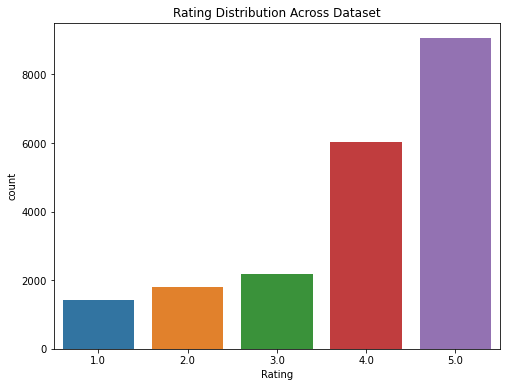

In [13]:
plt.figure(figsize=(8,6))
sns.countplot(df["Rating"])
plt.title("Rating Distribution Across Dataset")

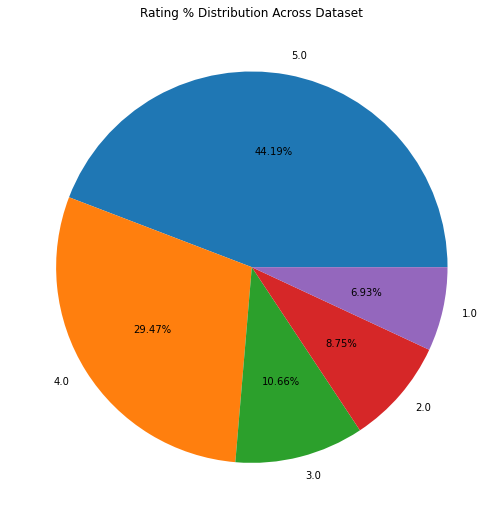

In [14]:
#Pie plot, the % of distribution of ratings across the dataset
plt.figure(figsize=(13,9))
plt.pie(df['Rating'].value_counts(),labels=['5.0','4.0','3.0','2.0','1.0'], autopct='%1.2f%%')
plt.title("Rating % Distribution Across Dataset")
plt.show()

<AxesSubplot:>

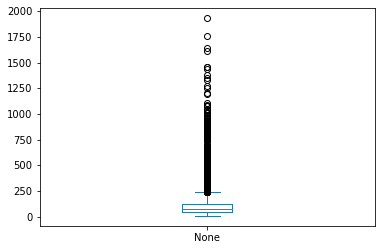

In [15]:
# Calculate review lengths
review_len = pd.Series([len(review.split()) for review in df['Review']])

# The distribution of review text lengths
review_len.plot(kind='box')

<AxesSubplot:ylabel='Count'>

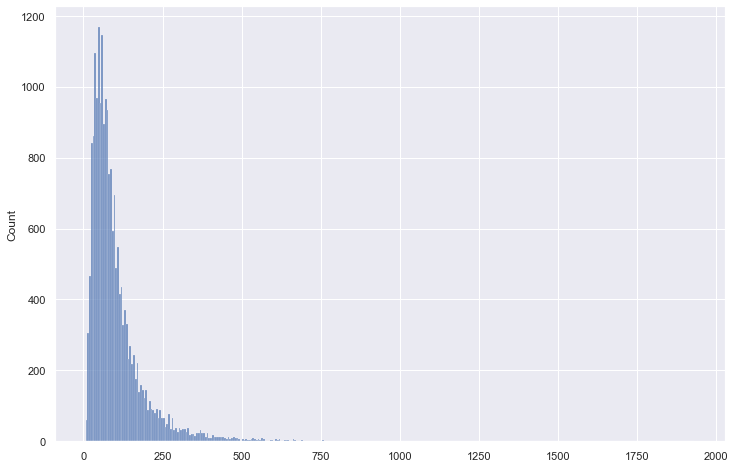

In [16]:
sns.set_theme(
    context='notebook',
    style='darkgrid',
    palette='deep',
    font='sans-serif',
    font_scale=1,
    color_codes=True,
    rc=None,
)
plt.figure(figsize=(12,8))
sns.histplot(review_len)

count    9054.000000
mean       93.963773
std        90.977999
min         7.000000
25%        44.000000
50%        69.000000
75%       111.000000
max      1755.000000
Name: Length, dtype: float64

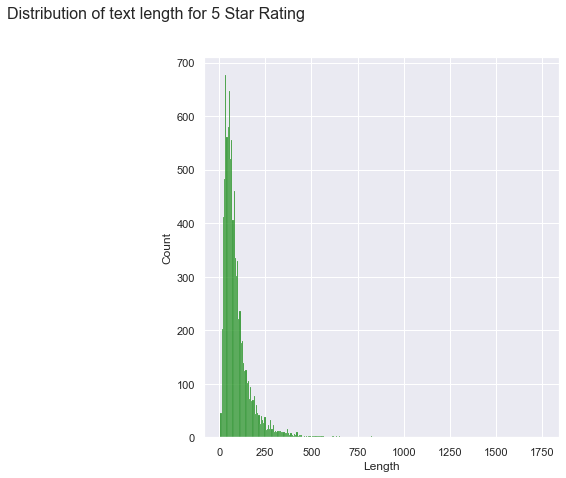

In [17]:
fig = plt.figure(figsize=(14,7))
df["Length"] = df.Review.str.split().apply(len)
ax1 = fig.add_subplot(122)
sns.histplot(df[df['Rating']==5]['Length'], ax=ax1,color='green')
fig.suptitle('Distribution of text length for 5 Star Rating', fontsize=16)
display(df.Length[df.Rating==5].describe())

count    1421.000000
mean      112.365236
std        99.834855
min        12.000000
25%        51.000000
50%        82.000000
75%       137.000000
max       954.000000
Name: Length, dtype: float64

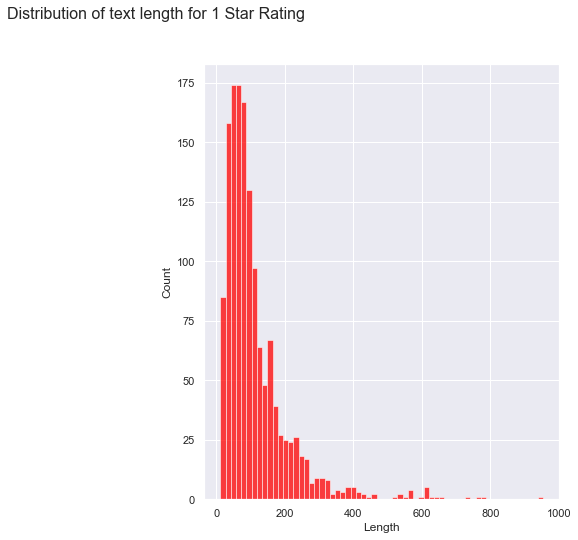

In [18]:
fig2 = plt.figure(figsize=(14,8))
ax2 = fig2.add_subplot(122)
sns.histplot(df[df["Rating"]==1]["Length"],ax=ax2,color='red')
fig2.suptitle("Distribution of text length for 1 Star Rating",fontsize=16)
display(df.Length[df.Rating==1].describe())

# WordCloud

In [19]:
from wordcloud import WordCloud

## WordCloud for Negatives Rating

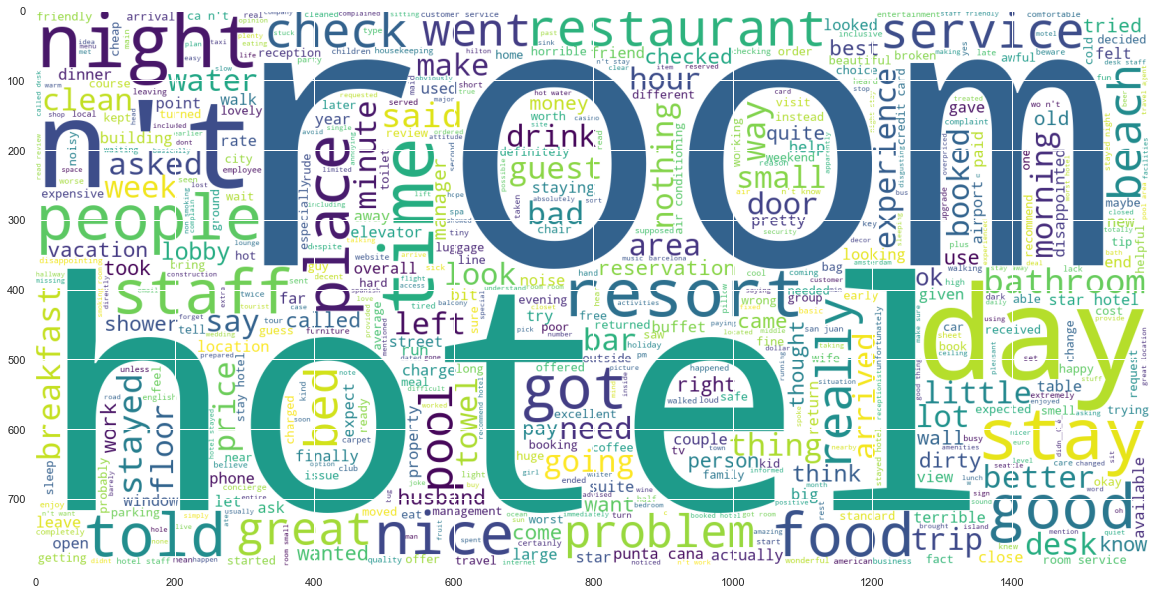

In [20]:
plt.figure(figsize=(20,20))
Neg_wc = WordCloud(max_words=2000, min_font_size=10, 
                height=800,width=1600,background_color="white").generate(" ".join(df[df["Rating"]<3].Review))
plt.imshow(Neg_wc)

## WordCloud for Neutral Rating

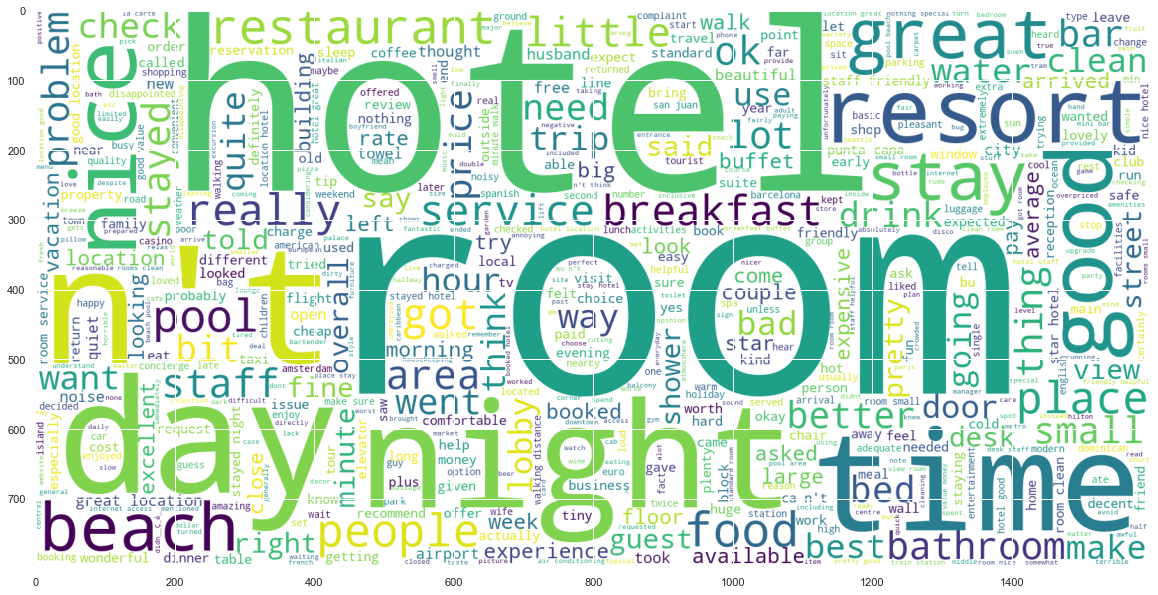

In [21]:
plt.figure(figsize=(20,20))
Neutral_wc = WordCloud(max_words=2000, min_font_size=10, 
                height=800,width=1600,background_color="white").generate(" ".join(df[df["Rating"]==3].Review))
plt.imshow(Neutral_wc)

## WordCloud for Positive  Rating

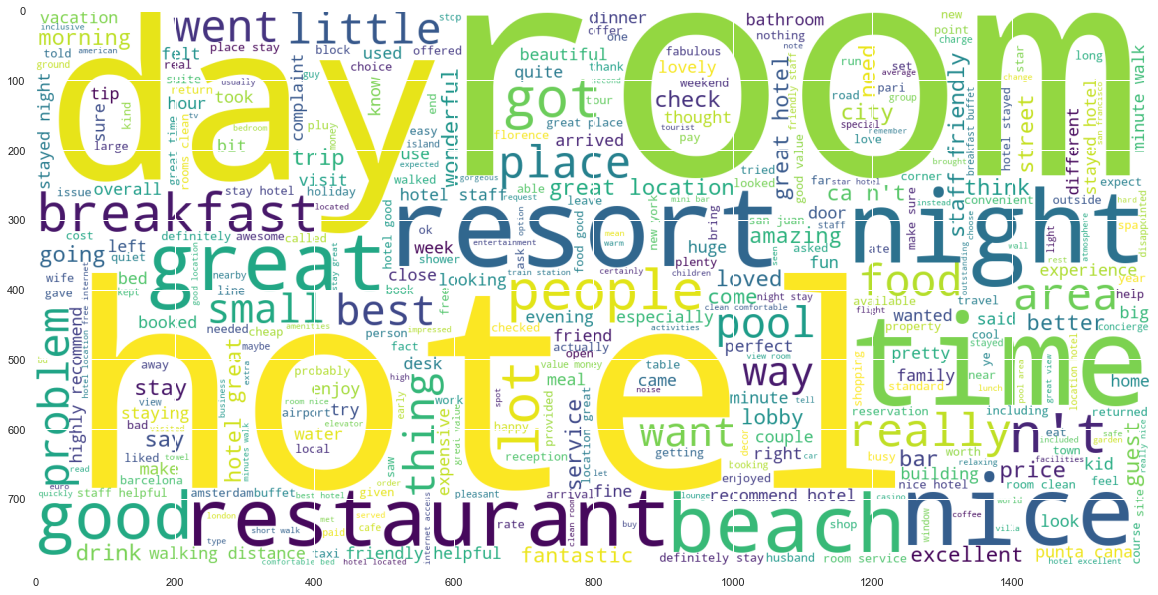

In [22]:
plt.figure(figsize=(20,20))
Pos_wc = WordCloud(max_words=2000, min_font_size=10, 
                height=800,width=1600,background_color="white").generate(" ".join(df[df["Rating"]>3].Review))
plt.imshow(Pos_wc)

# NLP Approach:
1. Cleaning
2. Lemmatization
3. TF-IDF

## 1. Data Cleaning Process

In [23]:
# function for cleaning Review
def standardize_text(df, field):
    df[field] = df[field].str.replace(r"http\S+", "")
    df[field] = df[field].str.replace(r"http","")
    df[field] = df[field].str.replace(r"@/S+","")
    df[field] = df[field].str.replace(r"[^A-Za-z(),!?@\'\`\"\_\n]", " ")
    df[field] = df[field].str.replace(r"@"," at ")
    df[field] = df[field].str.lower()
    return df

In [24]:
standardize_text(df,"Review")

,Review,Rating,Length
0,nice hotel expensive parking got good deal sta...,4.0,87
1,ok nothing special charge diamond member hilto...,2.0,250
2,nice rooms not experience hotel monaco seat...,3.0,217
3,"unique, great stay, wonderful time hotel monac...",5.0,89
4,"great stay great stay, went seahawk game aweso...",5.0,191
...,...,...,...
20486,"best kept secret rd time staying charm, not ...",5.0,109
20487,great location price view hotel great quick pl...,4.0,39
20488,"ok just looks nice modern outside, desk staff ...",2.0,63
20489,hotel theft ruined vacation hotel opened sept ...,1.0,781


In [25]:
import re
import string
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.stem.wordnet import WordNetLemmatizer
from nltk import word_tokenize

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\91864\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


## 2. Applying Lemmmatizer to remove tenses from texts.

In [26]:
lemmatizer = WordNetLemmatizer()
corpus = []
for i in range(0, len(df)):
    review = re.sub('[^a-zA-Z]', ' ', df['Review'][i])
    review = review.split()
    review = [word for word in review if not word in set(stopwords.words('english'))]
    review = [lemmatizer.lemmatize(word) for word in review]
    review = ' '.join(review)
    corpus.append(review)

In [27]:
corpus[:1]

['nice hotel expensive parking got good deal stay hotel anniversary arrived late evening took advice previous review valet parking check quick easy little disappointed non existent view room room clean nice size bed comfortable woke stiff neck high pillow soundproof like heard music room night morning loud bang door opening closing hear people talking hallway maybe noisy neighbor aveda bath product nice goldfish stay nice touch taken advantage staying longer location great walking distance shopping overall nice experience pay parking night']

In [28]:
def sentiment(review):
    if review>=3:
        return 1
    else:
        return 0
df['Sentiment']= df['Rating'].apply(sentiment)

In [29]:
df.head(10)

,Review,Rating,Length,Sentiment
0,nice hotel expensive parking got good deal sta...,4.0,87,1
1,ok nothing special charge diamond member hilto...,2.0,250,0
2,nice rooms not experience hotel monaco seat...,3.0,217,1
3,"unique, great stay, wonderful time hotel monac...",5.0,89,1
4,"great stay great stay, went seahawk game aweso...",5.0,191,1
5,love monaco staff husband stayed hotel crazy w...,5.0,134,1
6,"cozy stay rainy city, husband spent nights m...",5.0,101,1
7,"excellent staff, housekeeping quality hotel ch...",4.0,85,1
8,"hotel stayed hotel monaco cruise, rooms genero...",5.0,59,1
9,excellent stayed hotel monaco past w e delight...,5.0,35,1


## Polarity and subjectivity Score

In [30]:
import textblob
from textblob import TextBlob

In [31]:
df["Polarity_score"]=df['Review'].apply(lambda x:TextBlob(x).sentiment.polarity)
df["Subjectivity"]=df['Review'].apply(lambda x:TextBlob(x).sentiment.subjectivity)
df

,Review,Rating,Length,Sentiment,Polarity_score,Subjectivity
0,nice hotel expensive parking got good deal sta...,4.0,87,1,0.208744,0.687000
1,ok nothing special charge diamond member hilto...,2.0,250,0,0.197355,0.516630
2,nice rooms not experience hotel monaco seat...,3.0,217,1,0.267316,0.608081
3,"unique, great stay, wonderful time hotel monac...",5.0,89,1,0.504825,0.691228
4,"great stay great stay, went seahawk game aweso...",5.0,191,1,0.384615,0.629396
...,...,...,...,...,...,...
20486,"best kept secret rd time staying charm, not ...",5.0,109,1,0.212638,0.526768
20487,great location price view hotel great quick pl...,4.0,39,1,0.463333,0.600000
20488,"ok just looks nice modern outside, desk staff ...",2.0,63,0,0.171220,0.524304
20489,hotel theft ruined vacation hotel opened sept ...,1.0,781,0,0.124442,0.535807


## 3. Applying TF-IDF
Concept: Tfidf is meant for rendering more importance to the rare words. It so happens that if you rely on word counts alone, the unimportant words like ‘the’ , ‘and’ etc. will get more importance because they tend to get used more often.

In [32]:
from sklearn.feature_extraction.text import TfidfVectorizer
tfidf = TfidfVectorizer(ngram_range=(1, 3), max_features=10000, tokenizer = word_tokenize)
X = tfidf.fit_transform(corpus)
y = df['Sentiment']

# Splitting Data into Training and Testing Set 

In [33]:
from sklearn.model_selection import train_test_split

In [34]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size= 0.20, random_state=24)
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(16392, 10000)
(16392,)
(4099, 10000)
(4099,)


# Model Training... 

## Naive Bayes Classifier

In [35]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report

review_classifier_model=MultinomialNB()
review_classifier_model.fit(X_train,y_train)
review_classifier_model.score(X_test,y_test)

0.9148572822639668

In [36]:
print(classification_report(y_test,review_classifier_model.predict(X_test)))

              precision    recall  f1-score   support

           0       0.87      0.53      0.66       637
           1       0.92      0.99      0.95      3462

    accuracy                           0.91      4099
   macro avg       0.90      0.76      0.81      4099
weighted avg       0.91      0.91      0.91      4099



## Logistic Regression

In [37]:
from sklearn.linear_model import LogisticRegression
lr_model = LogisticRegression()
lr_model.fit(X_train, y_train)
lr_model.score(X_test, y_test)

0.9236399121737009

In [38]:
print(classification_report(y_test,lr_model.predict(X_test)))

              precision    recall  f1-score   support

           0       0.88      0.59      0.71       637
           1       0.93      0.99      0.96      3462

    accuracy                           0.92      4099
   macro avg       0.90      0.79      0.83      4099
weighted avg       0.92      0.92      0.92      4099



## Decision Tree

In [39]:
from sklearn.tree import DecisionTreeClassifier
dt_model=DecisionTreeClassifier()
dt_model.fit(X_train,y_train)
dt_model.score(X_test,y_test)

0.8536228348377654

In [40]:
print(classification_report(y_test,dt_model.predict(X_test)))

              precision    recall  f1-score   support

           0       0.53      0.51      0.52       637
           1       0.91      0.92      0.91      3462

    accuracy                           0.85      4099
   macro avg       0.72      0.71      0.72      4099
weighted avg       0.85      0.85      0.85      4099



## Random Forest

In [41]:
from sklearn.ensemble import RandomForestClassifier
rf_model=RandomForestClassifier()
rf_model.fit(X_train,y_train)
rf_model.score(X_test,y_test)

0.8926567455476946

In [42]:
print(classification_report(y_test,rf_model.predict(X_test)))

              precision    recall  f1-score   support

           0       0.92      0.34      0.49       637
           1       0.89      0.99      0.94      3462

    accuracy                           0.89      4099
   macro avg       0.91      0.67      0.72      4099
weighted avg       0.90      0.89      0.87      4099



### Ada Boost

In [43]:
from sklearn.ensemble import AdaBoostClassifier
ada_model=AdaBoostClassifier()
ada_model.fit(X_train,y_train)
ada_model.score(X_test,y_test)

0.9092461575994145

In [44]:
print(classification_report(y_test,ada_model.predict(X_test)))

              precision    recall  f1-score   support

           0       0.79      0.57      0.66       637
           1       0.92      0.97      0.95      3462

    accuracy                           0.91      4099
   macro avg       0.86      0.77      0.80      4099
weighted avg       0.90      0.91      0.90      4099



## XGBoost

In [45]:
from xgboost import XGBClassifier
xgb_model = XGBClassifier()
xgb_model.fit(X_train,y_train)

XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
              importance_type=None, interaction_constraints='',
              learning_rate=0.300000012, max_bin=256, max_cat_to_onehot=4,
              max_delta_step=0, max_depth=6, max_leaves=0, min_child_weight=1,
              missing=nan, monotone_constraints='()', n_estimators=100,
              n_jobs=0, num_parallel_tree=1, predictor='auto', random_state=0,
              reg_alpha=0, reg_lambda=1, ...)

In [46]:
xgb_model.score(X_test, y_test)

0.924127836057575

In [47]:
print(classification_report(y_test,xgb_model.predict(X_test)))

              precision    recall  f1-score   support

           0       0.85      0.62      0.72       637
           1       0.93      0.98      0.96      3462

    accuracy                           0.92      4099
   macro avg       0.89      0.80      0.84      4099
weighted avg       0.92      0.92      0.92      4099



## LightGBM

In [48]:
from lightgbm import LGBMClassifier
lgb_model = LGBMClassifier()
lgb_model.fit(X_train, y_train)
lgb_model.score(X_test, y_test)

0.9243717979995121

In [49]:
print(classification_report(y_test,lgb_model.predict(X_test)))

              precision    recall  f1-score   support

           0       0.84      0.63      0.72       637
           1       0.94      0.98      0.96      3462

    accuracy                           0.92      4099
   macro avg       0.89      0.81      0.84      4099
weighted avg       0.92      0.92      0.92      4099



### Out of all the Models we used, LightGBM model performes best with Accuracy of 92.5%. So, we are considering LightGBM Model.

# Prediction and Accuracy

In [50]:
y_pred = lgb_model.predict(X_test)

              precision    recall  f1-score   support

           0       0.63      0.84      0.72       479
           1       0.98      0.94      0.96      3620

    accuracy                           0.92      4099
   macro avg       0.81      0.89      0.84      4099
weighted avg       0.94      0.92      0.93      4099

Accuracy of LGB Model: 92.43717979995121%


Text(0.5, 1.0, 'Confusion Matrix for LGB Model')

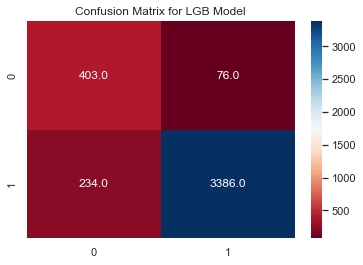

In [51]:
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
acc = accuracy_score(y_pred, y_test)
report = classification_report(y_pred, y_test)
print(report)
cm = confusion_matrix(y_pred, y_test)
#np.set_printoptions(precision=0.01)
print("Accuracy of LGB Model: {}%".format(acc*100))
sns.heatmap(cm, annot=True, fmt = ".1f",cmap="RdBu")
plt.title("Confusion Matrix for LGB Model")

# ROC_AUC Score and Curve
- The receiver operating characteristic (ROC) curve is a plot of the pairs of true positive rates (y-axis) and false positive rates (x-axis) that result from lowering the threshold down from 1, all the way to 0.

In [52]:
from sklearn.metrics import roc_auc_score, roc_curve
y_pred_proba = lgb_model.predict_proba(X_test)
pos_proba = y_pred_proba[:,1]

Text(0.5, 1.0, 'ROC curve for LGBM Classifier')

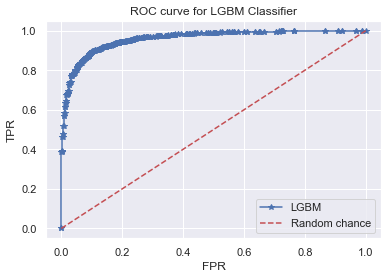

In [53]:
fpr, tpr, thersholds = roc_curve(y_test, pos_proba)
plt.plot(fpr, tpr, "*-")
plt.plot([0,1],[0,1],'r--')
plt.legend(['LGBM', 'Random chance'])
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.title('ROC curve for LGBM Classifier')

In [54]:
roc_auc_score(y_test, pos_proba)

0.9592163221774515

- Values closer to 1 in roc_auc_score shows that classifier is efficient and gives better performance.

# Saving The Model

In [55]:
import pickle
from pickle import dump
dump(lgb_model,open('model_sentiment.pkl','wb'))
dump(tfidf,open('model_sentiment_tfidf.pkl','wb'))